# Workpackage: Data engineering

Research Question:
**"How far can we simplify the input data to be still able to distinguish between Hand, Paper, and Scissors?"**

Research Answer:
We can simplify input pictures through by converting them to greyscale and reducing the resolution. Both methods can be used without loosing much of the needed elements. Additionaly we can blur the images, to remove details and only get rough shapes and then use segmentation methods like otsu to get a binary image with the shape of the hand. On simple and clear input images, this can work so good, that with the calculation of histograms one could distinguish the gestures without maschine learning at all. The drawbacks are, that one relies heavily on the selection of the segmentation method and thus needs to be carefully chosen. Another problem shows the segmentation of more complex data. There the segmentation with basic methods have shown to be very incorrect and partwise not usefull at all. But this could also be due to the fact that the implemented otsu method is a global threshold segmentation method, which is not siuted for this usecase. If one has a good segmentation method for this use case, one could as also implemented cut the background out, so that the ML algorithm just has to distinguish between face and hand if the segmentation method lacks of that capability.
**All in all the simplest robust image we were able to generate, which could optimize the training robustly is the blurred greyscale image, which has a reduced resolution. Further evaluation needs to be done if the blurring really benefits the training.**

In [3]:
import path as path
from scipy.ndimage.filters import gaussian_filter
import os, random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


def segment_otsu(img):
    bins_num = 256


    # Get the image histogram
    hist, bin_edges = np.histogram(img, bins=bins_num)

    # Get normalized histogram if it is required

    hist = np.divide(hist.ravel(), hist.max())

    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)

    threshold = bin_mids[:-1][index_of_max_val]
    print("Otsu's algorithm implementation thresholding result: ", threshold)
    result = np.zeros_like(img)
    result[img > threshold] = 255
    result[img <= threshold] = 0

    return result

def lower_resolution_image (image):
    return image.resize((80,60))

def blur_image(image):
    return gaussian_filter(image, sigma=1.5)


def get_data():
    dir = "../Dataset/structured_data/rock"
    file = random.choice(os.listdir(dir))
    path = os.path.join(dir, file)
    print(path)
    original_image = Image.open(path)
    greyscale_image = Image.open(path).convert('L')  # convert to grayscale

    return original_image, greyscale_image

def crop_image(original, image):
    summation_row_array = np.apply_along_axis(sum,axis=0,arr=image)
    summation_column_array = np.apply_along_axis(sum,axis=1,arr=image)
    delete_indices = []
    max_row_value = 0
    for index in range(len(summation_row_array)):
        if summation_row_array[index] == max_row_value:
            delete_indices.append(index)
        else:
            break

    for index in range(len(summation_row_array)-1,-1,-1):
        if summation_row_array[index] == max_row_value:
            delete_indices.append(index)
        else:
            break
    original = np.delete(original,delete_indices,axis=1)
    image = np.delete(image,delete_indices,axis=1)

    delete_indices = []
    max_column_value = 0
    for index in range(len(summation_column_array)):
        if summation_column_array[index] == max_column_value:
            delete_indices.append(index)
        else:
            break

    for index in range(len(summation_column_array)-1,-1,-1):
        if summation_column_array[index] == max_column_value:
            delete_indices.append(index)
        else:
            break
    original = np.delete(original,delete_indices,axis=0)
    image = np.delete(image,delete_indices,axis=0)

    return original, image

def delete_background(original, segmentation):
    original[segmentation == 0] = 255
    return original

def visualize_greyscale(image, name):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(image, cmap=plt.cm.gray)
    #ax.set_title(name)
    ax.axis('off')

def visualize_image(image,name):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(image)
    ax.set_title(name)
    ax.axis('off')

def create_histogram(image):
    column_data = np.zeros(image.shape[0])
    for column in range(image.shape[0]):
        column_data[column] = np.sum(image[column])
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(column_data, range(len(column_data)))
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_title('y plot')
    ax.axis('off')
    row_data = np.zeros(image.shape[1])

    for row in range(image.shape[1]):
        row_data[row] = image.sum(axis=0)[row]
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(range(len(row_data)), row_data)
    ax.set_title('x plot')
    ax.axis('off')


In [26]:
def segment_simple_use_case():
    original, greyscale = get_data()
    low_resolution = lower_resolution_image(greyscale)
    blurred = blur_image(low_resolution)
    segmented = segment_otsu(blurred)
    cropped_original, cropped = crop_image(low_resolution, segmented)
    background_deletion = delete_background(cropped_original, cropped)
    create_histogram(cropped)

    visualize_image(original,"Original image")
    visualize_greyscale(greyscale, "Grayscaling")
    visualize_greyscale(low_resolution, "Resolution reduction")
    visualize_greyscale(blurred, "Blurring")
    visualize_greyscale(segmented, "Segmentation")
    visualize_greyscale(cropped, "Centring and zooming in")
    visualize_greyscale(background_deletion, "original without background")



../Dataset/Rock_Paper_Sissors_Photos/train/scissors/glu_423.png
Otsu's algorithm implementation thresholding result:  122.734375


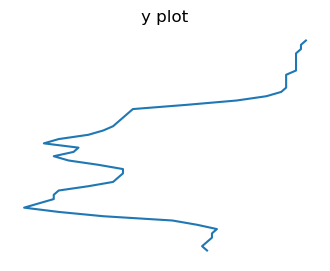

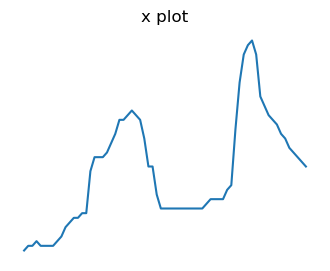

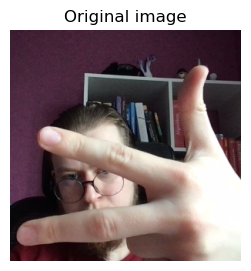

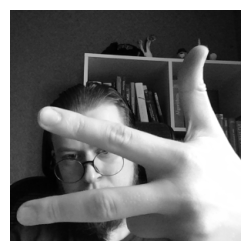

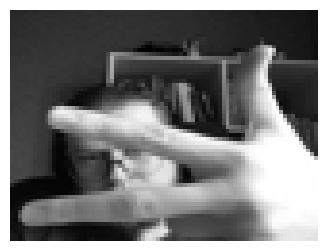

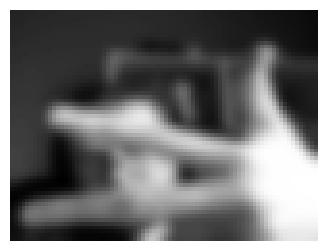

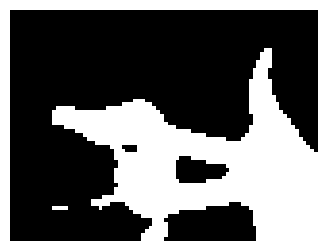

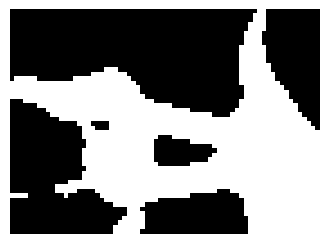

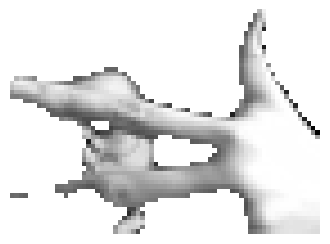

In [3]:
segment_simple_use_case()

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu
def multi_otsu(output_path, img):
# Setting the font size for all plots.
    matplotlib.rcParams['font.size'] = 9

# The input image.
    image = np.asarray(img)
# Applying multi-Otsu threshold for the default value, generating
# three classes.
    thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
    regions = np.digitize(image, bins=thresholds)

    plt.imshow(regions, cmap='gray')

# Remove axis and labels
    plt.axis('off')

# Save the image
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)



In [ ]:
dir = '../Dataset/finalData/rock'
i = 0
for filename in os.listdir(dir):
    if filename.endswith(".png"):
        path = os.path.join(dir, filename)
        image = Image.open(path).convert('L')
        output_path = '../Dataset/multi_otsu/rock/'+filename
        multi_otsu(output_path,image)
        i+=1
        print((i/len(os.listdir(dir)))*100)

0.06765899864682003
0.13531799729364005
0.20297699594046006
0.2706359945872801
0.3382949932341001
0.40595399188092013
0.4736129905277402
0.5412719891745602
0.6089309878213802
0.6765899864682002
0.7442489851150204
0.8119079837618403
0.8795669824086604
0.9472259810554804
1.0148849797023005
1.0825439783491204
1.1502029769959403
1.2178619756427604
1.2855209742895806
1.3531799729364005
1.4208389715832206
1.4884979702300407
1.5561569688768606
1.6238159675236805
1.6914749661705006
1.7591339648173208
1.8267929634641407
1.8944519621109608
1.962110960757781
2.029769959404601
2.097428958051421
2.165087956698241
2.2327469553450605
2.3004059539918806
2.3680649526387008
2.435723951285521
2.503382949932341
2.571041948579161
2.6387009472259813
2.706359945872801
2.774018944519621
2.841677943166441
2.9093369418132613
2.9769959404600814
3.0446549391069015
3.1123139377537212
3.1799729364005414
3.247631935047361
3.3152909336941816
3.3829499323410013
3.450608930987822
3.5182679296346415
3.585926928281461
3.

0.031675641431738996
0.06335128286347799
0.09502692429521697
0.12670256572695598
0.15837820715869497
0.19005384859043395
0.22172949002217296
0.25340513145391197
0.2850807728856509
0.31675641431738993
0.34843205574912894
0.3801076971808679
0.4117833386126069
0.4434589800443459
0.4751346214760849
0.5068102629078239


KeyboardInterrupt: 

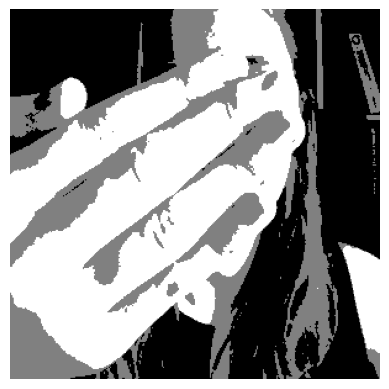

In [84]:
j = 0
dir2 = '../Dataset/finalData/paper'
for filename in os.listdir(dir2):
    if filename.endswith(".png"):
        path = os.path.join(dir2, filename)
        image = Image.open(path).convert('L')
        output_path = '../Dataset/multi_otsu/paper/'+filename
        multi_otsu(output_path,image)
        j+=1
        print((j/len(os.listdir(dir2)))*100)


0.031026993484331366
0.06205398696866273
0.09308098045299411
0.12410797393732546
0.15513496742165683
0.18616196090598822
0.21718895439031957
0.24821594787465093


KeyboardInterrupt: 

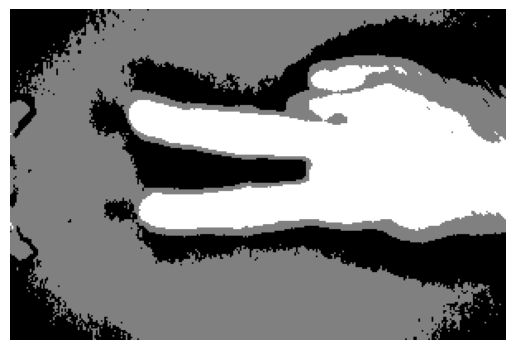

In [85]:
k = 0
dir3 = '../Dataset/finalData/scissors'
for filename in os.listdir(dir3):
    if filename.endswith(".png"):
        path = os.path.join(dir3, filename)
        image = Image.open(path).convert('L')
        output_path = '../Dataset/multi_otsu/scissors/'+filename
        multi_otsu(output_path,image)
        k+=1
        print((k/len(os.listdir(dir3)))*100)